In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size':15})
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
# from imblearn.under_sampling import ClusterCentroids

Using TensorFlow backend.


In [25]:
df = pd.read_csv("data.csv",index_col=[0])

In [5]:
df.shape

(179994, 602)

### 頻出100部品に絞る

In [3]:
sam1 = df.iloc[:, 3:].sum()

In [4]:
sam1 =sam1.sort_values(ascending=False)[100:]

In [5]:
sam1 = list(sam1.index)

In [6]:
df.drop(sam1, axis=1,inplace=True)

In [7]:
#除外する部品数
len(sam1)

499

### 100部品を含まない受付NOを除外

In [7]:
sam2 = df.iloc[:, 3:].sum(axis=1)

In [9]:
df.drop(list(sam2[sam2==0].index), axis=0,inplace=True)

In [10]:
df.drop('修理依頼内容',axis=1,inplace=True)

In [11]:
#ラベルエンコーディング
from sklearn.preprocessing import LabelEncoder
#LabelEncoderのインスタンスを生成
le = LabelEncoder()
#ラベルを覚えさせる
le = le.fit(df['大現象名'])
#ラベルを整数に変換
df['大現象名'] = le.transform(df['大現象名'])

In [12]:
#LabelEncoderのインスタンスを生成
le1 = LabelEncoder()
#ラベルを覚えさせる
le1 = le1.fit(df['商品品番'])
#ラベルを整数に変換
df['商品品番'] = le1.transform(df['商品品番'])

### 各特徴量の数

In [31]:
len(df.商品品番.unique())

7667

In [32]:
len(df.大現象名.unique())

19

In [17]:
df.iloc[:, 3:].sum().sort_values()

E53-126        492
E43-148        494
K100-165       495
E63-126B       498
H43-350        529
             ...  
50-1001       8531
34-1234       8933
50-1001-2     9770
50-2318      10871
TF-10R-L     33855
Length: 99, dtype: int64

In [18]:
df["E53-126"].value_counts()

0    140299
1       492
Name: E53-126, dtype: int64

In [21]:
492/(140299+492)*100

0.34945415545027736

# 層化抽出法を用いたK-分割交差検証を用いたダウンサンプリングでモデルを学習


# 100部品のモデルを作成し、精度評価

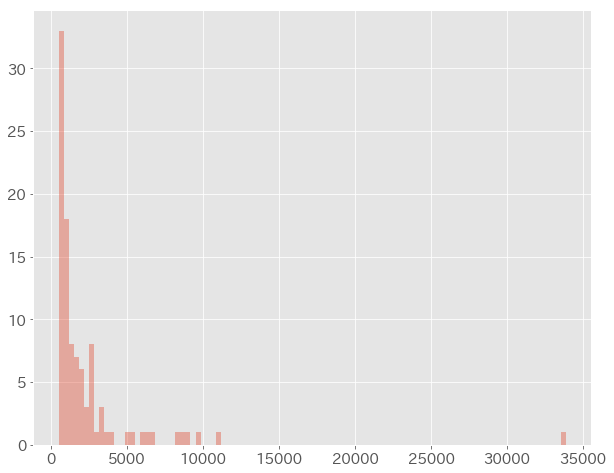

In [45]:
plt.figure(figsize=(10, 8))
sns.distplot(df.iloc[:, 2:].sum(), kde=False, rug=False, bins=100)

In [44]:
buhin = list(df.iloc[:, 2:].sum().sort_values(ascending=False).index)

In [15]:
#部品保存
import pickle
f = open('list.txt', 'wb')
pickle.dump(buhin, f)

In [18]:
import pickle
f = open('list1.txt', 'wb')
pickle.dump(buhin, f)

In [54]:
df.iloc[:, 2:].sum().describe()

count      100.0000
mean      2326.2100
std       3833.0113
min        492.0000
25%        739.7500
50%       1102.5000
75%       2486.2500
max      33855.0000
dtype: float64

## ランダムにリサンプリング

In [45]:
#結果を格納するデータフレーム
result_us = pd.DataFrame(0, columns=["F1","F2","F3","F4","F5"], index=buhin)
feature_importance = pd.DataFrame(0, columns=["Product","Phenomenon"], index=buhin)



In [50]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = df.loc[:, '商品品番':'大現象名'].values

for count,i in enumerate(buhin):
    
    sum_pro = 0.0
    sum_phe = 0.0
    
    y = df.loc[:,i]
    
    print(count)
    print('部品 :{}'.format(i))

    for k,(train_index, test_index) in enumerate(skf.split(X, y)):

    #     print(y[train_index].value_counts())

#         print(k)
#         print(i)
    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        
        if i == "TF-10R-L":
            
              # ランダムフォレストにて学習
            rfc = RandomForestClassifier(random_state=0)
            rfc.fit(X_train ,y_train)
            y_pred = rfc.predict(X_test)

            #F値を格納
            result_us.loc[i,"F{}".format(k+1)] = f1_score(y_test, rfc.predict(X_test))
            
        
        else:
        
            positive_count_train = y_train.sum()

            rus = RandomUnderSampler(ratio={0:positive_count_train*9, 1:positive_count_train}, random_state=0)
            X_train_resampled, y_train_resampled = rus.fit_sample(X_train, y_train)


    #         print('y_train_sample:\n{}'.format(pd.Series(y_train).value_counts()))
    #         print('y_train_resample:\n{}'.format(pd.Series(y_train_resampled).value_counts()))
    #         print('y_test_sample:\n{}'.format(pd.Series(y_test).value_counts()))

               # ランダムフォレストにて学習
            rfc = RandomForestClassifier(random_state=0)
            rfc.fit(X_train_resampled, y_train_resampled)
            y_pred = rfc.predict(X_test)

    #         print('f1 score: {:.4f}'.format(f1_score(y_test, y_pred)))

            #F値を格納
            result_us.loc[i,"F{}".format(k+1)] = f1_score(y_test, rfc.predict(X_test))
        
        
        #特徴量の重要度
        #商品品番
        pro = rfc.feature_importances_[0]
    
        #大現象名
        phe = rfc.feature_importances_[1]

        sum_pro = sum_pro + pro
        sum_phe = sum_phe + phe

    #特徴量重要度を格納
    feature_importance.loc[i,"Product"] = sum_pro/5
    feature_importance.loc[i,"Phenomenon"] = sum_phe/5
     

0
部品 :TF-10R-L
1
部品 :50-2318
2
部品 :50-1001-2
3
部品 :34-1234
4
部品 :50-1001
5
部品 :343-1011D
6
部品 :TF-20B
7
部品 :355-1054A
8
部品 :TK-KA-100
9
部品 :50-280(1P)
10
部品 :K30-126A
11
部品 :A-4939
12
部品 :343-1008D
13
部品 :TF-10R-S
14
部品 :50-156
15
部品 :331-1012D
16
部品 :A-4990
17
部品 :331-1013B
18
部品 :TF-10A
19
部品 :351-1038A
20
部品 :PK-500
21
部品 :H20-159
22
部品 :331-1009B
23
部品 :343-1018
24
部品 :311-1020
25
部品 :331-1001
26
部品 :341-1015A
27
部品 :343-1001D-PSET
28
部品 :61-1134
29
部品 :43-3010
30
部品 :311-1034
31
部品 :343-1017
32
部品 :314-1004
33
部品 :343-1020A
34
部品 :313-1010
35
部品 :314-1001
36
部品 :A-2186-AH
37
部品 :H20-126A
38
部品 :341-1010
39
部品 :50-15(1P)
40
部品 :K100-300
41
部品 :A-6021
42
部品 :343-1001B-PSET
43
部品 :50-186
44
部品 :343-1001D
45
部品 :A-2187
46
部品 :341-1021
47
部品 :A-4625A
48
部品 :50-528
49
部品 :K100-126A
50
部品 :34-1234-10
51
部品 :A-5897
52
部品 :K100-350
53
部品 :213-1020
54
部品 :343-1010C
55
部品 :H30-300
56
部品 :AT-1006
57
部品 :CF-930DB
58
部品 :50-195-10(1P)
59
部品 :A-4994
60
部品 :CWA-29
61
部品 :H20-126
62
部品 :313-1031A


In [51]:
result_us["F mean"] = result_us.mean(axis=1)

## Tomek links

In [22]:
#結果を格納するデータフレーム
result_tomek = pd.DataFrame(0, columns=["F1","F2","F3","F4","F5"], index=buhin)

In [55]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = df.loc[:, '商品品番':'大現象名'].values

for count,i in enumerate(buhin):
    
    y = df.loc[:,i]
    
    print(count)
    print('部品 :{}'.format(i))

    for k,(train_index, test_index) in enumerate(skf.split(X, y)):

    #     print(y[train_index].value_counts())

#         print(k)
#         print(i)
    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        positive_count_train = y_train.sum()

        #     'majority'：多数決クラスのみをリサンプリング
        tl = TomekLinks(ratio='majority',random_state=0)
    
        X_train_resampled, y_train_resampled = tl.fit_sample(X_train, y_train)


#         print('y_train_sample:\n{}'.format(pd.Series(y_train).value_counts()))
#         print('y_train_resample:\n{}'.format(pd.Series(y_train_resampled).value_counts()))
#         print('y_test_sample:\n{}'.format(pd.Series(y_test).value_counts()))

           # ランダムフォレストにて学習
        rfc = RandomForestClassifier(random_state=0)
        rfc.fit(X_train_resampled, y_train_resampled)
        y_pred = rfc.predict(X_test)

#         print('f1 score: {:.4f}'.format(f1_score(y_test, y_pred)))
        
        #F値を格納
        result_tomek.loc[i,"F{}".format(k+1)] = f1_score(y_test, rfc.predict(X_test))

0
部品 :TF-10R-L
1
部品 :50-2318
2
部品 :50-1001-2
3
部品 :34-1234
4
部品 :50-1001
5
部品 :343-1011D
6
部品 :TF-20B
7
部品 :355-1054A
8
部品 :TK-KA-100
9
部品 :50-280(1P)
10
部品 :K30-126A
11
部品 :A-4939
12
部品 :343-1008D
13
部品 :TF-10R-S
14
部品 :50-156
15
部品 :331-1012D
16
部品 :A-4990
17
部品 :331-1013B
18
部品 :TF-10A
19
部品 :351-1038A
20
部品 :PK-500
21
部品 :H20-159
22
部品 :331-1009B
23
部品 :343-1018
24
部品 :311-1020
25
部品 :331-1001
26
部品 :341-1015A
27
部品 :343-1001D-PSET
28
部品 :61-1134
29
部品 :43-3010
30
部品 :311-1034
31
部品 :343-1017
32
部品 :314-1004
33
部品 :343-1020A
34
部品 :313-1010
35
部品 :314-1001
36
部品 :A-2186-AH
37
部品 :H20-126A
38
部品 :341-1010
39
部品 :50-15(1P)
40
部品 :K100-300
41
部品 :A-6021
42
部品 :343-1001B-PSET
43
部品 :50-186
44
部品 :343-1001D
45
部品 :A-2187
46
部品 :341-1021
47
部品 :A-4625A
48
部品 :50-528
49
部品 :K100-126A
50
部品 :34-1234-10
51
部品 :A-5897
52
部品 :K100-350
53
部品 :213-1020
54
部品 :343-1010C
55
部品 :H30-300
56
部品 :AT-1006
57
部品 :CF-930DB
58
部品 :50-195-10(1P)
59
部品 :A-4994
60
部品 :CWA-29
61
部品 :H20-126
62
部品 :313-1031A


In [56]:
result_tomek["tomek F mean"] = result_tomek.mean(axis=1)

## ダウンサンプリングなし

In [58]:
#結果を格納するデータフレーム
result = pd.DataFrame(0, columns=["F1","F2","F3","F4","F5"], index=buhin)

In [59]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = df.loc[:, '商品品番':'大現象名'].values

for i in buhin:
    
    y = df.loc[:,i]
    
    print('部品 :{}'.format(i))

    for k,(train_index, test_index) in enumerate(skf.split(X, y)):

    #     print(y[train_index].value_counts())

#         print(k)
#         print(i)
    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


           # ランダムフォレストにて学習
        rfc = RandomForestClassifier(random_state=0)
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_test)

#         print('f1 score: {:.4f}'.format(f1_score(y_test, y_pred)))
        
        #F値を格納
        result.loc[i,"F{}".format(k+1)] = f1_score(y_test, rfc.predict(X_test))

部品 :TF-10R-L
部品 :50-2318
部品 :50-1001-2
部品 :34-1234
部品 :50-1001
部品 :343-1011D
部品 :TF-20B
部品 :355-1054A
部品 :TK-KA-100
部品 :50-280(1P)
部品 :K30-126A
部品 :A-4939
部品 :343-1008D
部品 :TF-10R-S
部品 :50-156
部品 :331-1012D
部品 :A-4990
部品 :331-1013B
部品 :TF-10A
部品 :351-1038A
部品 :PK-500
部品 :H20-159
部品 :331-1009B
部品 :343-1018
部品 :311-1020
部品 :331-1001
部品 :341-1015A
部品 :343-1001D-PSET
部品 :61-1134
部品 :43-3010
部品 :311-1034
部品 :343-1017
部品 :314-1004
部品 :343-1020A
部品 :313-1010
部品 :314-1001
部品 :A-2186-AH
部品 :H20-126A
部品 :341-1010
部品 :50-15(1P)
部品 :K100-300
部品 :A-6021
部品 :343-1001B-PSET
部品 :50-186
部品 :343-1001D
部品 :A-2187
部品 :341-1021
部品 :A-4625A
部品 :50-528
部品 :K100-126A
部品 :34-1234-10
部品 :A-5897
部品 :K100-350
部品 :213-1020
部品 :343-1010C
部品 :H30-300
部品 :AT-1006
部品 :CF-930DB
部品 :50-195-10(1P)
部品 :A-4994
部品 :CWA-29
部品 :H20-126
部品 :313-1031A
部品 :341-1039
部品 :355-1078A
部品 :313-1016
部品 :A-2028-AH
部品 :A-3665
部品 :H32-139
部品 :343-1031
部品 :314-1005
部品 :41-1254
部品 :A-4989
部品 :343-1001B
部品 :A-6858
部品 :A-4025
部品 :314-1021
部品 :

In [60]:
result["noresumple F mean"] = result.mean(axis=1)

In [65]:
result_base = pd.concat([result["noresumple F mean"], result_us["F mean"],result_tomek["tomek F mean"]], axis=1)

In [66]:
result_base.to_csv("result_base.csv")

In [53]:
result_us["F mean"] = result_us.mean(axis=1)

In [54]:
result_us

,F1,F2,F3,F4,F5,F mean
TF-10R-L,0.750000,0.760563,0.758509,0.759738,0.759662,0.757695
50-2318,0.817645,0.823802,0.816525,0.809068,0.819749,0.817358
50-1001-2,0.180762,0.166545,0.181754,0.182474,0.168498,0.176007
34-1234,0.558644,0.558582,0.555297,0.558501,0.561002,0.558405
50-1001,0.281605,0.275910,0.282264,0.286850,0.266571,0.278640
...,...,...,...,...,...,...
H43-350,0.297810,0.297059,0.284542,0.321027,0.318328,0.303753
E63-126B,0.900901,0.844828,0.862222,0.831858,0.853448,0.858651
K100-165,0.233645,0.204836,0.227474,0.228412,0.244898,0.227853
E43-148,0.564706,0.614379,0.605096,0.559271,0.508021,0.570294


In [59]:
feature_importance = pd.concat([result_us["F mean"],feature_importance], axis=1)

In [60]:
feature_importance.to_csv("feature_importance.csv")